In [17]:
from vibdata.deep.DeepDataset import convertDataset
import vibdata.raw as raw_datasets
from vibdata.deep.signal.transforms import Sequential,SplitSampleRate,FeatureExtractor,FilterByValue

# Get raw root_dir
raw_root_dir = "../data/raw_data/cwru"
raw_dataset = raw_datasets.CWRU_raw(raw_root_dir, download=True)

In [18]:
from vibdata.deep.signal.transforms import Kurtosis,RootMeanSquare,StandardDeviation,Mean,LogAttackTime,TemporalDecrease,TemporalCentroid,EffectiveDuration,ZeroCrossingRate
import numpy as np
from scipy.stats import skew
from vibdata.deep.signal.transforms import Transform

class PeakValue(Transform):
    def __init__(self):
        super().__init__()

    def transform(self, data):
        return np.max(np.abs(data["signal"]))
    
class CrestFactor(Transform):
    def __init__(self):
        super().__init__()

    def transform(self, data):
        signal = data["signal"]
        rms = np.sqrt(sum(np.square(signal)) / len(signal))
        if rms == 0:
            return 0
        return np.max(np.abs(signal)) / rms
    
class Skewness(Transform):
    def __init__(self):
        super().__init__()

    def transform(self, data):
        signal = data["signal"]
        return skew(signal)

class ClearanceFactor(Transform):
    def __init__(self):
        super().__init__()

    def transform(self, data):
        signal = data["signal"]
        peak_value = np.max(np.abs(signal))
        base = sum(np.sqrt(np.square(signal))) / len(signal)
        return peak_value / base
    
class ImpulseFactor(Transform):
    def __init__(self):
        super().__init__()

    def transform(self, data):
        signal = data["signal"]
        peak_value = np.max(np.abs(signal))
        mean_value = np.mean(np.abs(signal))
        if mean_value == 0:
            return 0
        return peak_value / mean_value

class ShapeFactor(Transform):
    def __init__(self):
        super().__init__()

    def transform(self, data):
        signal = data["signal"]
        rms = np.sqrt(sum(np.square(signal)) / len(signal))
        mean_value = np.mean(np.abs(signal))
        if mean_value == 0:
            return 0
        return rms / mean_value

class UpperBoundValueHistogram(Transform):
    def __init__(self, bins=10):
        super().__init__()
        self.bins = bins

    def transform(self, data):
        signal = data["signal"]
        max = np.max(signal)
        min = np.min(signal)
        return max + ( (0.5 * (max - min) ) / (len(signal) - 1) )
    
class LowerBoundValueHistogram(Transform):
    def __init__(self, bins=10):
        super().__init__()
        self.bins = bins

    def transform(self, data):
        signal = data["signal"]
        max = np.max(signal)
        min = np.min(signal)
        return min + ( (0.5 * (max - min) ) / (len(signal) - 1) )

class Variance(Transform):
    def __init__(self):
        super().__init__()

    def transform(self, data):
        signal = data["signal"]
        return np.var(signal)
    
class PeakToPeak(Transform):
    def __init__(self):
        super().__init__()

    def transform(self, data):
        signal = data["signal"]
        return np.ptp(signal)  # Peak to peak value

features_funcs = [Kurtosis(),
            RootMeanSquare(),
            StandardDeviation(),
            Mean(),
            LogAttackTime(),
            TemporalDecrease(),
            TemporalCentroid(),
            EffectiveDuration(),
            ZeroCrossingRate(),
            PeakValue(),
            CrestFactor(),
            Skewness(),
            ClearanceFactor(),
            ImpulseFactor(), 
            ShapeFactor(),
            UpperBoundValueHistogram(),
            LowerBoundValueHistogram(),
            Variance(),
            PeakToPeak()
            ]

transforms = Sequential(
    [   
        SplitSampleRate(),
        FeatureExtractor(features=features_funcs),
    ]
)
print(transforms)


Sequential(transforms=[SplitSampleRate(),
                       FeatureExtractor(features=[Kurtosis(), RootMeanSquare(),
                                                  StandardDeviation(), Mean(),
                                                  LogAttackTime(),
                                                  TemporalDecrease(),
                                                  TemporalCentroid(),
                                                  EffectiveDuration(),
                                                  ZeroCrossingRate(),
                                                  PeakValue(), CrestFactor(),
                                                  Skewness(), ClearanceFactor(),
                                                  ImpulseFactor(),
                                                  ShapeFactor(),
                                                  UpperBoundValueHistogram(),
                                                  LowerBoundValueHistogram(),
    

In [19]:
deep_root_dir = "../data/deep_data/features_igor"
deep_dataset = convertDataset(raw_dataset, filter=FilterByValue(on_field="sample_rate", values=12000) ,transforms=transforms, dir_path=deep_root_dir, batch_size=32)

In [20]:
print(len(deep_dataset))

2520


In [21]:
deep_dataset[0]

{'metainfo': fault_size                     0.0
 load                           0.0
 file_name                   97.mat
 variable_name         X097_DE_time
 axis                            DE
 domain                        time
 sample_size                 243938
 rotation_hz                  29.95
 label                            0
 sample_rate                  12000
 component_location             NaN
 Name: 0, dtype: object,
 'signal': array([[-1.30400614e-01,  7.40817826e-02,  7.31644452e-02,
          1.16221543e-02, -6.31093621e-01, -1.92399346e-03,
          5.33847332e-01,  9.77916658e-01,  1.66999996e-01,
          2.72868923e-01,  3.68334715e+00, -8.58499789e-02,
          4.59623230e+00,  4.59623230e+00,  1.24784119e+00,
          2.47439527e-01, -2.72847243e-01,  5.35303604e-03,
          5.20286769e-01]])}

In [22]:
import os

import numpy as np
import numpy.typing as npt
from tqdm import tqdm
from vibdata.deep.DeepDataset import DeepDataset
from vibdata.deep.signal.core import SignalSample
from signalAI.utils.group_dataset import GroupDataset
from signalAI.utils.fold_idx_generator import FoldIdxGeneratorUnbiased, FoldIdxGeneratorBiased

class GroupMultiRoundCWRULoad(GroupDataset):
    @staticmethod
    def _assigne_group(sample: SignalSample) -> int:
        sample_metainfo = sample["metainfo"]
        return sample_metainfo["label"].astype(str) + " " + sample_metainfo["load"].astype(int).astype(str)

class GroupCWRULoad(GroupDataset):
    @staticmethod
    def _assigne_group(sample: SignalSample) -> int:
        return sample["metainfo"]["load"]
    
class GroupCWRUSeverity(GroupDataset):
    @staticmethod
    def _assigne_group(sample: SignalSample) -> int:
        severity = sample["metainfo"]["fault_size"]
        
        match severity:
            case 0.0:
                return sample["metainfo"]["load"]
            case 0.007:
                return 0
            case 0.014:
                return 1
            case 0.021:
                return 2
            case 0.028:
                return 3
        
        return None

In [23]:
folds_singleround = FoldIdxGeneratorUnbiased(deep_dataset, GroupCWRULoad , dataset_name="CWRU").generate_folds()
folds_singleround

Loading group dataset from: ../data/grouping/groups_CustomGroupCWRU.npy


array([0., 0., 0., ..., 3., 3., 3.])

In [ ]:
CLASS_DEF = {0: "N", 1: "O", 2: "I", 3: "R"}
CONDITION_DEF = {"0": "0", "1": "1", "2": "2", "3": "3"}
folds_multiround = FoldIdxGeneratorUnbiased(deep_dataset,
                                    GroupMultiRoundCWRULoad ,
                                    dataset_name="CWRU12k",
                                    multiround=True,
                                    class_def=CLASS_DEF,
                                    condition_def=CONDITION_DEF).generate_folds()
folds_multiround

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from signalAI.experiments.features_1d import Features1DExperiment
import numpy as np
import scipy
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=9)
sfs = SequentialFeatureSelector(knn, n_features_to_select=5)
kbest =  SelectKBest(f_classif, k=9)

# 1. Criar e executar experimento
experiment = Features1DExperiment(
    name="Vibration_Analysis_RF",
    description="Análise de vibração com RandomForest e features no domínio do tempo",
    feature_names= features_funcs,
    dataset=deep_dataset,
    data_fold_idxs=folds_multiround,
    n_inner_folds=4,
    #feature_selector=kbest,
    model=RandomForestClassifier(random_state=42),
    model_parameters_search_space = {
        "model__n_estimators": [50,100,200],
        "model__criterion": ["gini", "entropy","log_loss"],
        "model__max_depth": [10, 25, 50],
        "model__min_samples_split": [2, 5, 10]
    }
)

results = experiment.run()


### Rodada 1/8 ###

=== Fold Externo 1/4 ===
Fitting 4 folds for each of 81 candidates, totalling 324 fits
  Teste - Acurácia: 0.7233, F1: 0.7253

=== Fold Externo 2/4 ===
Fitting 4 folds for each of 81 candidates, totalling 324 fits
  Teste - Acurácia: 0.8391, F1: 0.8382

=== Fold Externo 3/4 ===
Fitting 4 folds for each of 81 candidates, totalling 324 fits
  Teste - Acurácia: 0.8719, F1: 0.8705

=== Fold Externo 4/4 ===
Fitting 4 folds for each of 81 candidates, totalling 324 fits
  Teste - Acurácia: 0.8266, F1: 0.8256

=== Resultados Finais ===
Acurácia Média: 0.8152 ± 0.0556
F1-Score Médio: 0.8149 ± 0.0543
Changed working directory to: results_1d_features/vibration_analysis_results_Vibration_Analysis_RF_20250916_121931

### Rodada 2/8 ###

=== Fold Externo 1/4 ===
Fitting 4 folds for each of 81 candidates, totalling 324 fits
  Teste - Acurácia: 0.8033, F1: 0.8036

=== Fold Externo 2/4 ===
Fitting 4 folds for each of 81 candidates, totalling 324 fits
  Teste - Acurácia: 0.8812, F1:

EXPERIMENTO: Vibration_Analysis_RF
DESCRIÇÃO: Análise de vibração com RandomForest e features no domínio do tempo
MODELO: RandomForestClassifier
QUANTIDADE DE FOLDS: 4
QUANTIDADE DE FEATURES: 19

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.7936
Desvio Padrão Acurácia ±0.0452
        F1-Score Médio  0.7924
Desvio Padrão F1-Score ±0.0441

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.7456   0.7439    0.7582 0.7456
    2   0.8400   0.8379    0.8384 0.8400
    3   0.8375   0.8349    0.8365 0.8375
    4   0.7513   0.7530    0.7552 0.7513


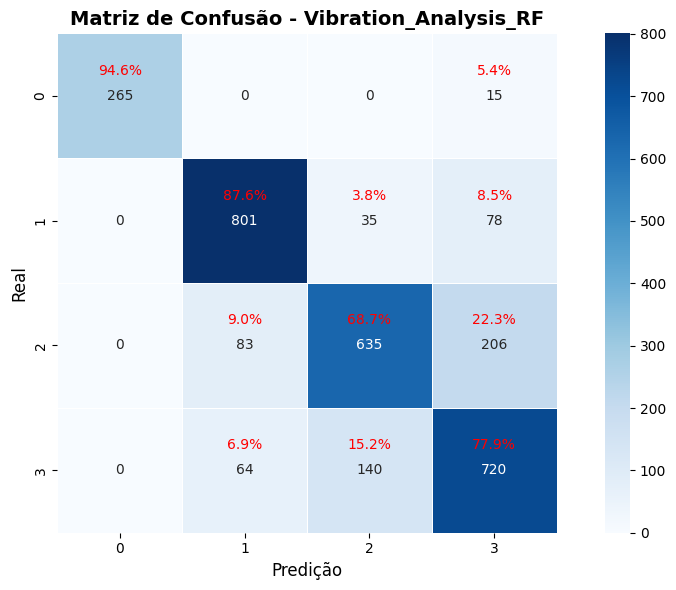


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.7959
Total de Amostras: 3042


In [ ]:
from signalAI.experiments.features_1d import ExperimentResults
import pandas as pd

# read the json from multiround experiment


loaded_results = ExperimentResults.load_json(f"/home/vbbonella/mestrado/tese-mestrado/experiments_notebooks/results_torch/vibration_analysis_results_cnn1d_vibration_20251007_150941/torch_results_20251007_150941.json")

loaded_results.show_results()